<a href="https://colab.research.google.com/github/minnji88/DeepLearning2020/blob/master/8_4%20%EB%B3%80%EC%9D%B4%ED%98%95_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기술적으로 보면 VAE는 다음과 같이 작동합니다.

1. 인코더 모듈이 입력 샘플 input_img를 잠재 공간의 두 파라미터 z_mean과 z_log_var로 변환합니다.
2. 입력 이미지가 생성되었다고 가정한 잠재 공간의 정규 분포에서 포인트 z를 z = z_mean + exp(0.5 * z_log_var) * epsilon 처럼 무작위로 샘플링합니다. epsilon은 작은 값을 가진 랜덤 텐서입니다.
3. 디코더 모듈은 잠재 공간의 이 포인트를 원본 입력 이미지로 매핑하여 복원합니다.
epsilon이 무작위로 만들어지기 때문에 image_img를 인코딩한 잠재 공간의 위치(z_mean)에 가까운 포인트는 input_img와 비슷한 이미지로 디코딩될 것입니다. 이는 잠재 공간을 연속적이고 의미 있는 공간으로 만들어 줍니다. 잠재 공간의 저차원 연속성은 잠재 공간에서 모든 방향이 의미 있는 데이터 변화의 축을 인코딩하도록 만듭니다. 결국 잠재 공간은 매우 구조적이고 개념 벡터로 다루기에 적합해집니다.

VAE 파라미터는 2개의 손실 함수로 훈련합니다. 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실(reconstruction loss) 과 잠재 공간을 잘 형성하고 훈련 데이터에 과대적합을 줄이는 규제 손실(regularization loss) 입니다. 케라스의 VAE 구현을 간단히 보면 다음과 같습니다.



In [4]:
!pip uninstall keras
!pip uninstall tensorflow

# !pip install keras==2.2.5
# !pip install tensorflow==1.15.0

!pip install keras==2.2.4
!pip install tensorflow==2.2

Uninstalling Keras-2.3.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.3.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.3.1
Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0
     |████████████████████████████████| 317kB 4.1MB/s 
ERROR: fancyimpute 0.4.3 requires t

  Using cached https://files.pythonhosted.org/packages/3d/be/679ce5254a8c8d07470efb4a4c00345fae91f766e64f1c2aece8796d7218/tensorflow-2.2.0-cp36-cp36m-manylinux2010_x86_64.whl


In [7]:
# 코드 8-23 VAE 인코더 네트워크
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # 잠재 공간의 차원: 2D 평면

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

 z_mean과 z_log_var를 사용하는 코드입니다. 이 두 파라미터가 input_img를 생성한 통계 분포의 파라미터라고 가정하고 잠재 공간 포인트 z를 생성합니다. 여기에서 (케라스의 백엔드 기능으로 만든) 일련의 코드를 Lambda 층으로 감쌉니다. 케라스에서는 모든 것이 층이므로 기본 층을 사용하지 않은 코드는 Lambda로 (또는 직접 만든 층으로) 감싸야 합니다.

In [8]:
# 코드 8-24 잠재 공간 샘플링 함수
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

다음 코드는 디코더 구현입니다. 벡터 z를 이전 특성 맵 차원으로 크기를 바꾸고 몇 개의 합성곱 층을 사용해 최종 출력 이미지를 만듭니다. 최종 이미지는 원본 input_img와 차원이 같습니다.


In [9]:
# 코드 8-25 잠재 공간 포인트를 이미지로 매핑하는 VAE 디코더 네트워크
# Input에 z를 주입합니다
decoder_input = layers.Input(K.int_shape(z)[1:])

# 입력을 업샘플링합니다
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# 인코더 모델의 마지막 Flatten 층 직전의 특성 맵과 같은 크기를 가진 특성 맵으로 z의 크기를 바꿉니다
x = layers.Reshape(shape_before_flattening[1:])(x)

# Conv2DTranspose 층과 Conv2D 층을 사용해 z를 원본 입력 이미지와 같은 크기의 특성 맵으로 디코딩합니다
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# 특성 맵의 크기가 원본 입력과 같아집니다

# 디코더 모델 객체를 만듭니다
decoder = Model(decoder_input, x)

# 모델에 z를 주입하면 디코딩된 z를 출력합니다
z_decoded = decoder(z)

일반적인 샘플 기준의 함수인 loss(y_true, y_pred) 형태는 VAE의 이중 손실에 맞지 않습니다. add_loss 내장 메서드를 사용하는 층을 직접 만들어 임의의 손실을 정의하겠습니다.

In [10]:
# 코드 8-26 VAE 손실을 계산하기 위해 직접 만든 층

class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # 출력 값을 사용하지 않습니다
        return x

# 입력과 디코딩된 출력으로 이 층을 호출하여 모델의 최종 출력을 얻습니다
y = CustomVariationalLayer()([input_img, z_decoded])

이제 모델 객체를 만들고 훈련할 준비가 되었습니다. 층에서 손실을 직접 다루기 때문에 compile 메서드에서 손실을 지정하지 않습니다(loss=None). 그 결과 훈련하는 동안 타깃 데이터를 전달하지 않아도 됩니다(다음 코드처럼 모델의 fit 메서드에 x_train만 전달합니다)

In [11]:
# 코드 8-27 VAE 훈련하기
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

# MNIST 숫자 이미지에서 VAE를 훈련합니다
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

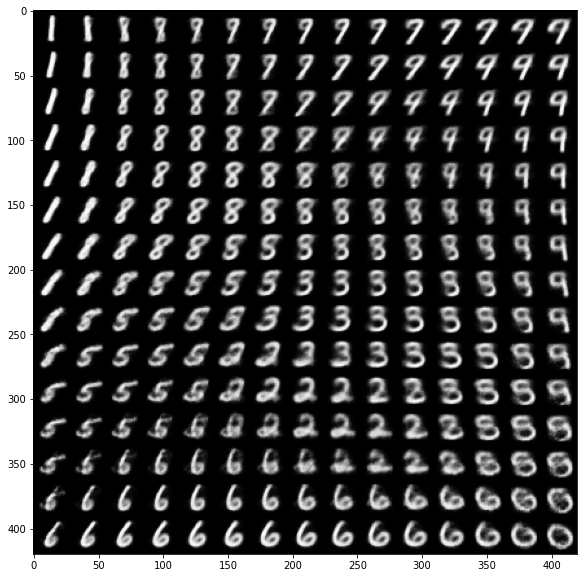

In [13]:
# 코드 8-28 2D 잠재 공간에서 포인트 그리드를 샘플링하여 이미지로 디코딩하기

import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # 15 × 15 숫자의 그리드를 출력합니다
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 싸이파이 ppf 함수를 사용하여 일정하게 떨어진 간격마다 잠재 변수 z의 값을 만듭니다
# 잠재 공간의 사전 확률은 가우시안입니다
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

샘플링된 숫자의 그리드는 다른 숫자 클래스 사이에서 완벽하게 연속된 분포를 보여줍니다. 잠재 공간의 한 경로를 따라서 한 숫자가 다른 숫자로 자연스럽게 바뀝니다. 이 공간의 특정 방향은 어떤 의미를 가집니다. 예를 들어 ‘6으로 가는 방향’, ‘9로 가는 방향’ 등입니다.